<a href="https://colab.research.google.com/github/Sayed-Husain/medical-papers-skimmers/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

In this notebook,  we're going to be replicating the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

The purpose of this model is to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature and dive deeper when necessary.

## Check for a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-43e56617-9bd0-9c58-f66e-2fb128951fbe)


## Get data

Since we are replicating a paper, we are going to download and use the same dataset they used avaliable on: https://github.com/Franck-Dernoncourt/pubmed-rct.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experimnet using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data
Now we have got some text data, it is time make a function to read in all of teh lines of a target text file

In [6]:
# Create a function to read lines of a document
def get_lines(filename):
  """
  Reads a filename and returns the lines of text as a list.
  
  Args:
    filename (str): string of the target filepath
  
  Returns:
    A list of strings with one string per line from target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# let's read in the training lines 
train_lines = get_lines(data_dir + "train.txt")
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how the data would be best represnted.

```
[{'line_number':0,
   'target': 'OBJECTIVE',
   'text': "To investigate the efficacy of @ weeks of daily low-dose oral ...",
   'total_lines':11},
   ...]
```

In [9]:
def pre_process_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its content and sort thorugh each line,
  extracting things like target label, the text of the sentence, 
  how many sentences are in the current abstract 
  and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # Create an empty abstarct
  abstract_samples = [] # Create an empty list of abstracts
  
  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line in an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if teh line is an ID line
    
    elif line.isspace(): # Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstratcs into separate lines
      # Iterate through each line in a single abstarct and count them at the same time
      for abstarct_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictonary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["line_number"] = abstarct_line_number
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get text label and turn it into lower case
        line_data["total_lines"] = len(abstract_line_split) - 1 # total number of lines starting from 0
    
        abstract_samples.append(line_data)
        

    else: # if the above confitions are not fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [10]:
# Get data from file and preprocess it
%%time
train_samples = pre_process_text_with_line_numbers(data_dir + "train.txt")
val_samples = pre_process_text_with_line_numbers(data_dir + "dev.txt")
test_samples = pre_process_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 587 ms, sys: 119 ms, total: 706 ms
Wall time: 1.02 s


(180040, 30212, 30135)

In [11]:
train_samples[0]

{'line_number': 0,
 'target': 'OBJECTIVE',
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'total_lines': 11}

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to futher visualize it. 

In [12]:
import pandas as pd 
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(12)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

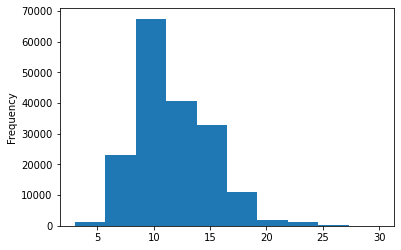

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences


In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels

### One hot encoding

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

### Label encoding

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model Experiments...

We are going to create different models and compare them to find which one works best.

We are going to start with a baseline (TF-IDF Multinomial Naive Bayes Classifier).

### Create a function to evaluate models

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Model 0: Baseline

In [20]:
# Create a baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data 
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
model_0_preds = model_0.predict(val_sentences)

# Evalaute the model
model_0_results = calculate_results(val_labels_encoded,
                                    model_0_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Prepare data for deep learning models

Before we start building deep learning models, we have to create a vectorization and an embedding layers.

In [23]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
# Get average sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(1.0, 296.0)

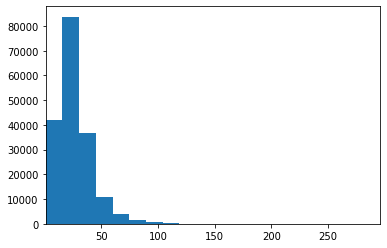

In [25]:
# Get the disributrion
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)
plt.xlim((np.min(sent_lens),np.max(sent_lens)))

In [26]:
# Get the sentence length that covers 95% of the sentences
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

#### Create a text vectorization layer
A layer to map texts from words to numbers.

In [27]:
# set max_tokens size (how many unique words in our vocabulary list)
MAX_TOKENS = 68000

In [28]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=MAX_TOKENS, # Number of words in vocabulary
                                     output_sequence_length=output_seq_len) # Desired output length of vectorized swquences

In [29]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [30]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n")
print(f"Length of text: {len(target_sentence)}\n")
print(f"Vectorized text: {text_vectorizer([target_sentence])}")

Text:
this prospective randomised study was conducted in @ patients who underwent implantation of different targets of monofocal intraocular lens for each eye at konkuk university medical center between november @ and august @ .

Length of text: 222

Vectorized text: [[   23   241   210    17    10   198     5    12    67   352  1087     4
    197  2357     4 10671  1944  1613    11   122   672    15 54116   735
    274   768    30  2223     3  2030     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [31]:
# How many words we have in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [32]:
# Get teh config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Create custom text embedding

In [33]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of the vocabulary
                               output_dim=128,
                               mask_zero=True, # use masking to handle variables sequence lengths
                               name="token_embedding")

In [34]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Sentence after embedding shape: {embedded_sentence.shape}\n")



Sentence before vectorization:
 this prospective randomised study was conducted in @ patients who underwent implantation of different targets of monofocal intraocular lens for each eye at konkuk university medical center between november @ and august @ .

Sentence after vectorization (before embedding):
 [[   23   241   210    17    10   198     5    12    67   352  1087     4
    197  2357     4 10671  1944  1613    11   122   672    15 54116   735
    274   768    30  2223     3  2030     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.03237858  0.02107934 -0.03208493 ... -0.01779637  0.03925118
    0.01363827]
  [ 0.03100029  0.00129715 -0.01659269 ...  0.02358213  0.00180501
   -0.02959865]
  [-0.01798359  0.02388157 -0.03089592 ...  0.03610057 -0.02468034
   -0.03478373]
  ...
  [ 0.01467422  0.009771   -0.03475117 ... -0.01352165  0.00473189
  

### Creating datasets 
make sure that data loads as fast as possible using TensorFlow tf.data API.

In [35]:
# Turn our data into TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embedding

In [37]:
# Create 1D conv model to proecss sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize the inputs
token_embedding = token_embed(text_vectors) # Create embeddings
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="Model_1_Conv1D")

model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_1.summary()

Model: "Model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)              

In [38]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=validation_dataset,
                              validation_steps=int(0.1 * len(train_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 13ms/step - loss: 0.9092 - accuracy: 0.6418 - val_loss: 0.6748 - val_accuracy: 0.7470
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6515 - accuracy: 0.7603 - val_loss: 0.6318 - val_accuracy: 0.7764
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6124 - accuracy: 0.7784 - val_loss: 0.5886 - val_accuracy: 0.7911


In [39]:
# Evalaute on the whole validation dataset 
model_1.evaluate(validation_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5945 - accuracy: 0.7870


[0.5944989323616028, 0.7870051860809326]

In [40]:
# Make predictions 
model_1_pred_probs = model_1.predict(validation_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[6.4268994e-01, 3.9369428e-01, 1.6693328e-01, 5.3122586e-01,
         9.0810731e-02],
        [7.1377701e-01, 6.6627705e-01, 8.0369532e-02, 5.8882207e-01,
         6.9677711e-02],
        [7.4438804e-01, 9.0140224e-02, 3.7387986e-02, 9.4325656e-01,
         8.1096363e-04],
        ...,
        [8.3891796e-03, 3.0420384e-01, 4.3198800e-01, 4.5116451e-03,
         9.9881291e-01],
        [1.5415074e-01, 5.7012600e-01, 2.5996298e-01, 1.7017950e-01,
         5.4373288e-01],
        [5.3222293e-01, 8.5929650e-01, 2.4106221e-01, 2.4813345e-01,
         2.7053392e-01]], dtype=float32), (30212, 5))

In [41]:
# Convert pred probs to classes 
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [42]:
# Caculate results
model_1_results = calculate_results(val_labels_encoded,
                                   model_1_preds)
model_1_results

{'accuracy': 78.70051635111876,
 'precision': 0.7841282368438953,
 'recall': 0.7870051635111877,
 'f1': 0.7846855221156539}

### Model 2: Feature extraction with pretrained token embeddings

For this porblem we will use the Universal Sentence Encoder USE: https://tfhub.dev/google/universal-sentence-encoder/4

In [43]:
# Download pretrained TensorFlow HUB USE 
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [44]:
# Test out pretrained embedding on a random sentence
target_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {target_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([target_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}\n")

Random Sentence:
 to explore the better therapy in the treatment of ganglion .

Sentence after embedding:
[ 0.04847997  0.01188158  0.04172084 -0.05228816 -0.06558721 -0.08244911
 -0.00650651 -0.04931514  0.03789597 -0.00016965  0.09699742  0.00023101
  0.01897785 -0.04637821  0.01274388 -0.02859685 -0.09559465 -0.01594878
  0.03661008 -0.01419919 -0.04254562 -0.02932024 -0.00439213 -0.05988047
 -0.01795587  0.05335183 -0.02836026  0.00667106  0.02429613  0.01179901]

Length of sentence embedding:
512



In [45]:
# Build modle_2 
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embeddings)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extraction")

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [46]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch = int(0.1 * len(train_dataset)),
                            validation_data=validation_dataset,
                            validation_steps=int(0.1 * len(validation_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9184 - accuracy: 0.6489 - val_loss: 0.7966 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7668 - accuracy: 0.7020 - val_loss: 0.7519 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7505 - accuracy: 0.7113 - val_loss: 0.7360 - val_accuracy: 0.7138


In [47]:
# Evalaute the model on the entire validation dataset
model_2.evaluate(validation_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7383 - accuracy: 0.7155


[0.7383192181587219, 0.7154772877693176]

In [48]:
# Make predicitons
model_2_pred_probs = model_2.predict(validation_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

# Caculate results
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

945/945 [==============================] - 13s 14ms/step


{'accuracy': 71.54772937905469,
 'precision': 0.7156714727521937,
 'recall': 0.7154772937905468,
 'f1': 0.7124385453507878}

### Model 3: Cov1D with character embeddings

#### Create a character level tokinizer

The original paper we are replicating states that they have used a combination of token and character-level embeddings.

Previously, we have created token-level embeddings, so let's try doing a similar steps for characters-level embeddings.

In [49]:
# Make a function to split sentences into characters 
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequences into characters
split_chars(target_sentence)

't o   e x p l o r e   t h e   b e t t e r   t h e r a p y   i n   t h e   t r e a t m e n t   o f   g a n g l i o n   .'

In [50]:
# Split sequence-level data into character-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [51]:
# Get the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(1.0, 1386.0)

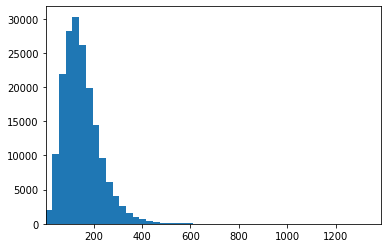

In [52]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=50)
plt.xlim(np.min(char_lens), np.max(char_lens))

In [53]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [54]:
# Create a char-level token vectorizer instance
char_vectorizer = TextVectorization(max_tokens=28,  
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [55]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [56]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c o m p l i c a t i o n   r a t e s   ,   l e n g t h s   o f   h o s p i t a l   s t a y   ,   a n d   h o s p i t a l   c o s t s   w e r e   s i m i l a r   b e t w e e n   t h e   t w o   g r o u p s   .

Length of chars: 87

Vectorized chars:
[[11  7 15 14 12  4 11  5  3  4  7  6  8  5  3  2  9 12  2  6 18  3 13  9
   7 17 13  7  9 14  4  3  5 12  9  3  5 19  5  6 10 13  7  9 14  4  3  5
  12 11  7  9  3  9 20  2  8  2  9  4 15  4 12  5  8 22  2  3 20  2  2  6
   3 13  2  3 20  7 18  8  7 16 14  9  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

#### Create a character level embedding


In [57]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # embedding dimension of each character
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
c o m p l i c a t i o n   r a t e s   ,   l e n g t h s   o f   h o s p i t a l   s t a y   ,   a n d   h o s p i t a l   c o s t s   w e r e   s i m i l a r   b e t w e e n   t h e   t w o   g r o u p s   .

Embedded chars (after vectorization and embedding):
[[[ 0.00719731  0.01879544  0.04582436 ...  0.0078434  -0.04363674
   -0.04790069]
  [-0.03822314  0.0470212  -0.04152723 ... -0.04378517 -0.02450076
    0.01862837]
  [ 0.01318843 -0.00574738 -0.0156761  ...  0.00134398  0.02606035
    0.04691653]
  ...
  [-0.01668446  0.02289185 -0.01547325 ...  0.04457921 -0.04176478
   -0.01304568]
  [-0.01668446  0.02289185 -0.01547325 ...  0.04457921 -0.04176478
   -0.01304568]
  [-0.01668446  0.02289185 -0.01547325 ...  0.04457921 -0.04176478
   -0.01304568]]]

Character embedding shape: (1, 290, 25)


In [58]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Build the model

In [59]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=10, padding="same", activation="relu")(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_char_level_embedding_Conv1D")


# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_char_level_embedding_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           16064     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (N

In [60]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch= int(0.1 * len(train_char_dataset)),
                              validation_data= val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2079 - accuracy: 0.5110 - val_loss: 0.9831 - val_accuracy: 0.6127
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9484 - accuracy: 0.6293 - val_loss: 0.8801 - val_accuracy: 0.6599
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8693 - accuracy: 0.6624 - val_loss: 0.8146 - val_accuracy: 0.6848


In [61]:
# Evaluate the model on the entire validation dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.8296 - accuracy: 0.6838


[0.8295587301254272, 0.6837680339813232]

In [62]:
# Make predicitons
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

# Caculate results
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 68.3768039189726,
 'precision': 0.6769558874777138,
 'recall': 0.683768039189726,
 'f1': 0.6738579361355014}

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer) 

1. Create a token-level embedding model
2. Create a character-level model
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of outputs on top of 3
5. Construct a model which takes token and character-level sequences as input and produce sequence label probabilities as output.

Steps inspired by the original paper

In [63]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(token_inputs, token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token adn char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropput
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [64]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

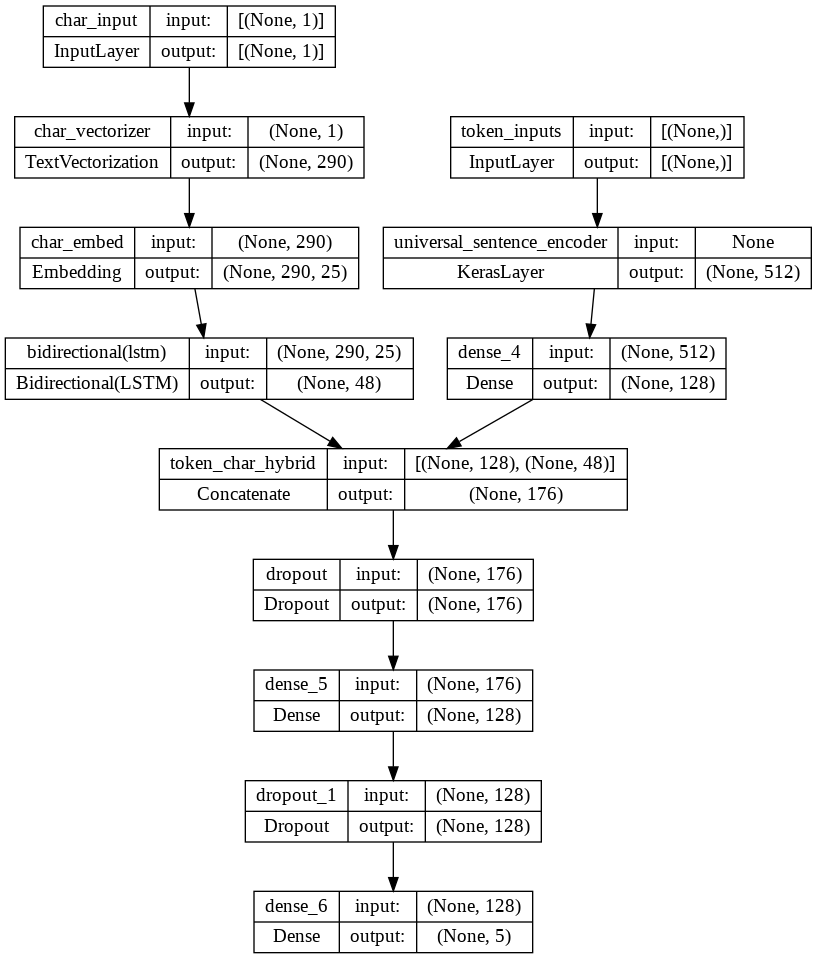

In [65]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [66]:
# Compile model_4
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

#### Combining token and character data into a tf.data Dataset

In [67]:
# For Training Data

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_data_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_data_labels)) # combine data with labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For Validation Data

# Combine chars and tokens into a dataset for validation dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_data_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_data_labels)) # combine data with labels

# Prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [68]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting a model on token and character-level sequences

In [69]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 42ms/step - loss: 0.9890 - accuracy: 0.6051 - val_loss: 0.7939 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 23s 41ms/step - loss: 0.8055 - accuracy: 0.6916 - val_loss: 0.7198 - val_accuracy: 0.7281
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.7753 - accuracy: 0.7036 - val_loss: 0.6980 - val_accuracy: 0.7354


In [70]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 23s 25ms/step - loss: 0.6981 - accuracy: 0.7323


[0.6981067657470703, 0.7322918176651001]

In [71]:
# Make predicitons
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

# Caculate results
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

945/945 [==============================] - 22s 22ms/step


{'accuracy': 73.22918045809612,
 'precision': 0.7352129979045996,
 'recall': 0.7322918045809612,
 'f1': 0.7296076397372668}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + postional embeddings



In [72]:
pd.DataFrame(train_df, columns=["line_number", "total_lines", "target"]).corr()

,line_number,total_lines
line_number,1.000,0.392
total_lines,0.392,1.000


In [73]:
train_df

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
...,...,...,...,...
180035,7,RESULTS,for the absolute change in percent atheroma vo...,11
180036,8,RESULTS,"for pav , a significantly greater percentage o...",11
180037,9,RESULTS,both strategies had acceptable side effect pro...,11
180038,10,CONCLUSIONS,"compared with standard statin monotherapy , th...",11


#### Create positional embeddings

In [74]:
# Get the disribution of the "line_number" column across the dataset
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

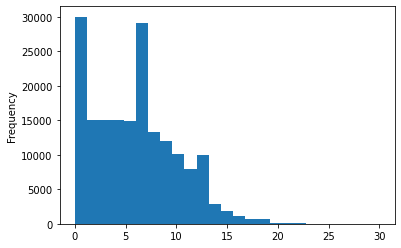

In [75]:
train_df["line_number"].plot.hist(bins=25);

As the vast majority of **`line_number`** values are less to or equal to **15**, we will use **15** as the depth of our one-hot-encoded tensors

In [76]:
# Use Tensorflow to create a one-hot-encoded tesnros of our "line_number" column
train_line_number_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

train_line_number_one_hot[:14], train_line_number_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we have encoded our line numbers feature, let's do the same for our total lines feature.

In [77]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

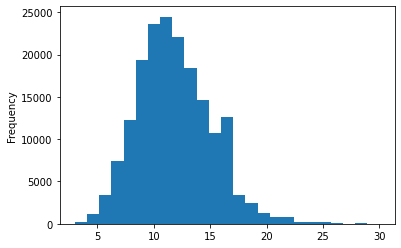

In [78]:
train_df["total_lines"].plot.hist(bins=25);

As the vast majority of **`total_lines`** values are less to or equal to **20**, we will use **20** as the depth of our one-hot-encoded tensors

In [79]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. create a model for `total_lines` feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3 & 4 & 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribried embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 adn outputs of into a `tf.keras.Model`

In [80]:
# 1. Token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs,
                             name="Token_Level_Model")


# 2. Char-Level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name="Character_Level_Model")

# 3. Line_Number Model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x,
                                   name="Line_Number_Model")

# 4. Total_Lines Model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y,
                                   name="Total_Lines_Model")

# 5. Combine Token_Level Model and the Char_Level Model
combine_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation="relu")(combine_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create the output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [81]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

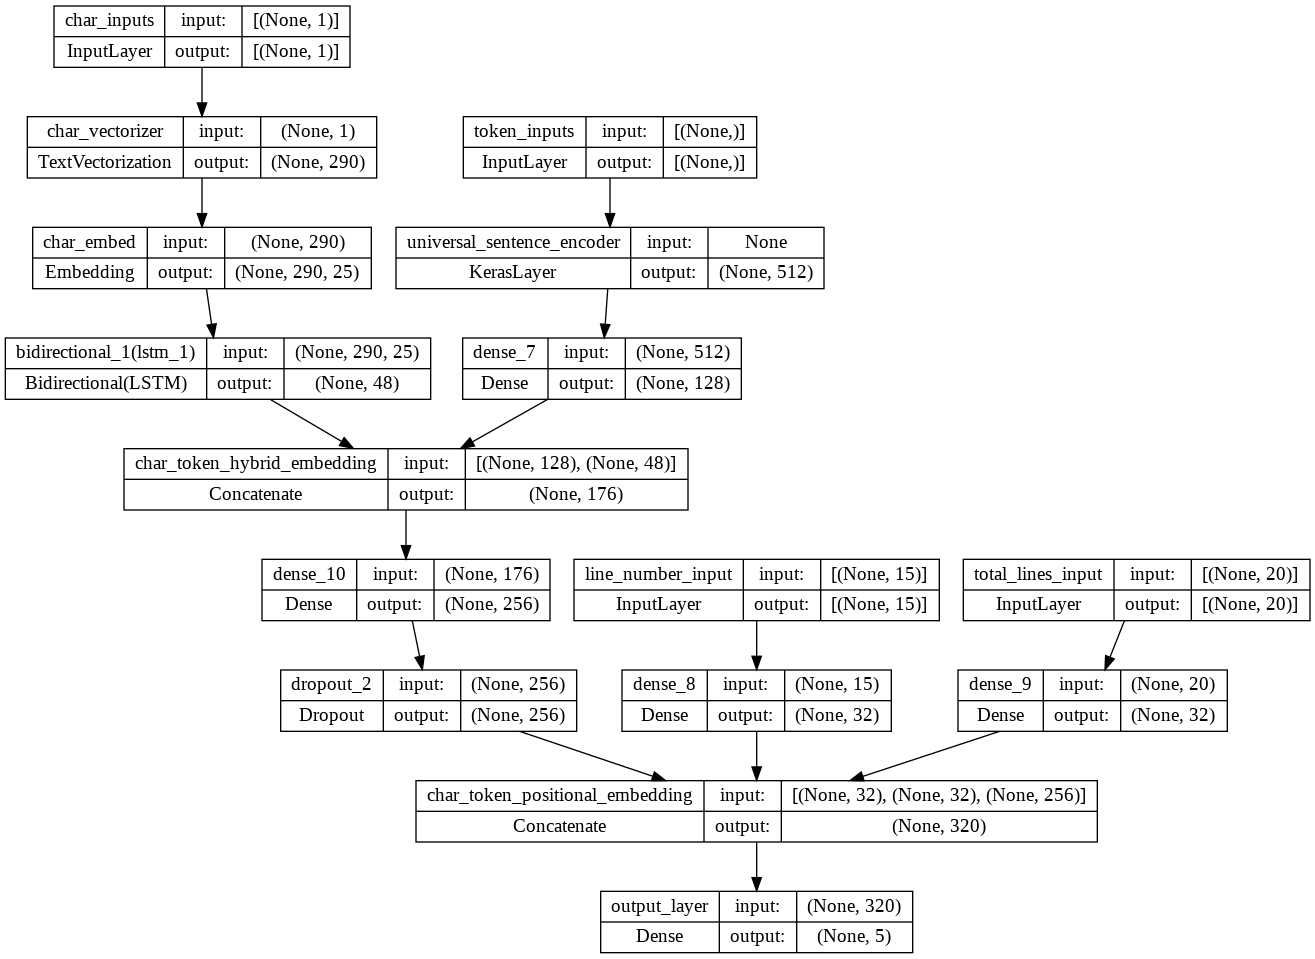

In [82]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [83]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics=["accuracy"])

#### Create tribrid embedding datasets using tf.data

In [84]:
# Create training and validation datasets with all four kinds of input data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [85]:
# Check input shape
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fit, evaluate, and make predictions with model_5

In [86]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 40ms/step - loss: 1.0992 - accuracy: 0.7233 - val_loss: 0.9810 - val_accuracy: 0.8092
Epoch 2/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9686 - accuracy: 0.8165 - val_loss: 0.9492 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9524 - accuracy: 0.8216 - val_loss: 0.9368 - val_accuracy: 0.8341


In [87]:
# Evaluate the model
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.9378 - accuracy: 0.8313


[0.9377655982971191, 0.8313252925872803]

In [88]:
# Make predicitons
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

# Caculate results
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

945/945 [==============================] - 30s 31ms/step


{'accuracy': 83.13253012048193,
 'precision': 0.8299569602499689,
 'recall': 0.8313253012048193,
 'f1': 0.8303285593557591}

### Model 6: custom token embeddings + character embeddings + postional embeddings   


Mixing between Model 1 and Model 5 


#### Building a tribrid embedding model with custom token embeddings

1. Create a token-level model using Conv1D layer **Same as model_1**
2. Create a character-level model **Same as model_5**
3. Create a model for the `line_number` feature **Same as model_5**
4. create a model for `total_lines` feature **Same as model_5**
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate` **Same as model_5**
6. Combine the outputs of 3 & 4 `tf.keras.layers.Concatenate` 
7. Combine the outputs of 5 & 6 `tf.keras.layers.Concatenate` 
8. Create an output layer to accept the tribried embedding and output label probabilities **Same as model_5**
9. Combine the inputs of 1, 2, 3, 4 adn outputs of into a `tf.keras.Model` **Same as model_5**

In [89]:
# 1. Token-level model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize the inputs
token_embedding = token_embed(text_vectors) # Create embeddings
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)

token_model = tf.keras.Model(inputs=inputs,
                             outputs =x,
                             name="Token_Level_Model")

# 2. Char-Level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name="Character_Level_Model")

# 3. Line_Number Model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x,
                                   name="Line_Number_Model")

# 4. Total_Lines Model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y,
                                   name="Total_Lines_Model")

# 5. Combine Token_Level Model and the Char_Level Model
combine_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation="relu")(combine_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine line_number model and total_lines model
postional_embeddings = layers.Concatenate(name="positional_embedding")([line_number_model.output,
                                                                        total_lines_model.output])

# 7. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([postional_embeddings,
                                                                                 z])

# 8. Create the output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 9. Put together model with all kinds of inputs
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                         outputs=output_layer,
                         name="model_6_tribrid_embedding_model")

In [90]:
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics=["accuracy"])

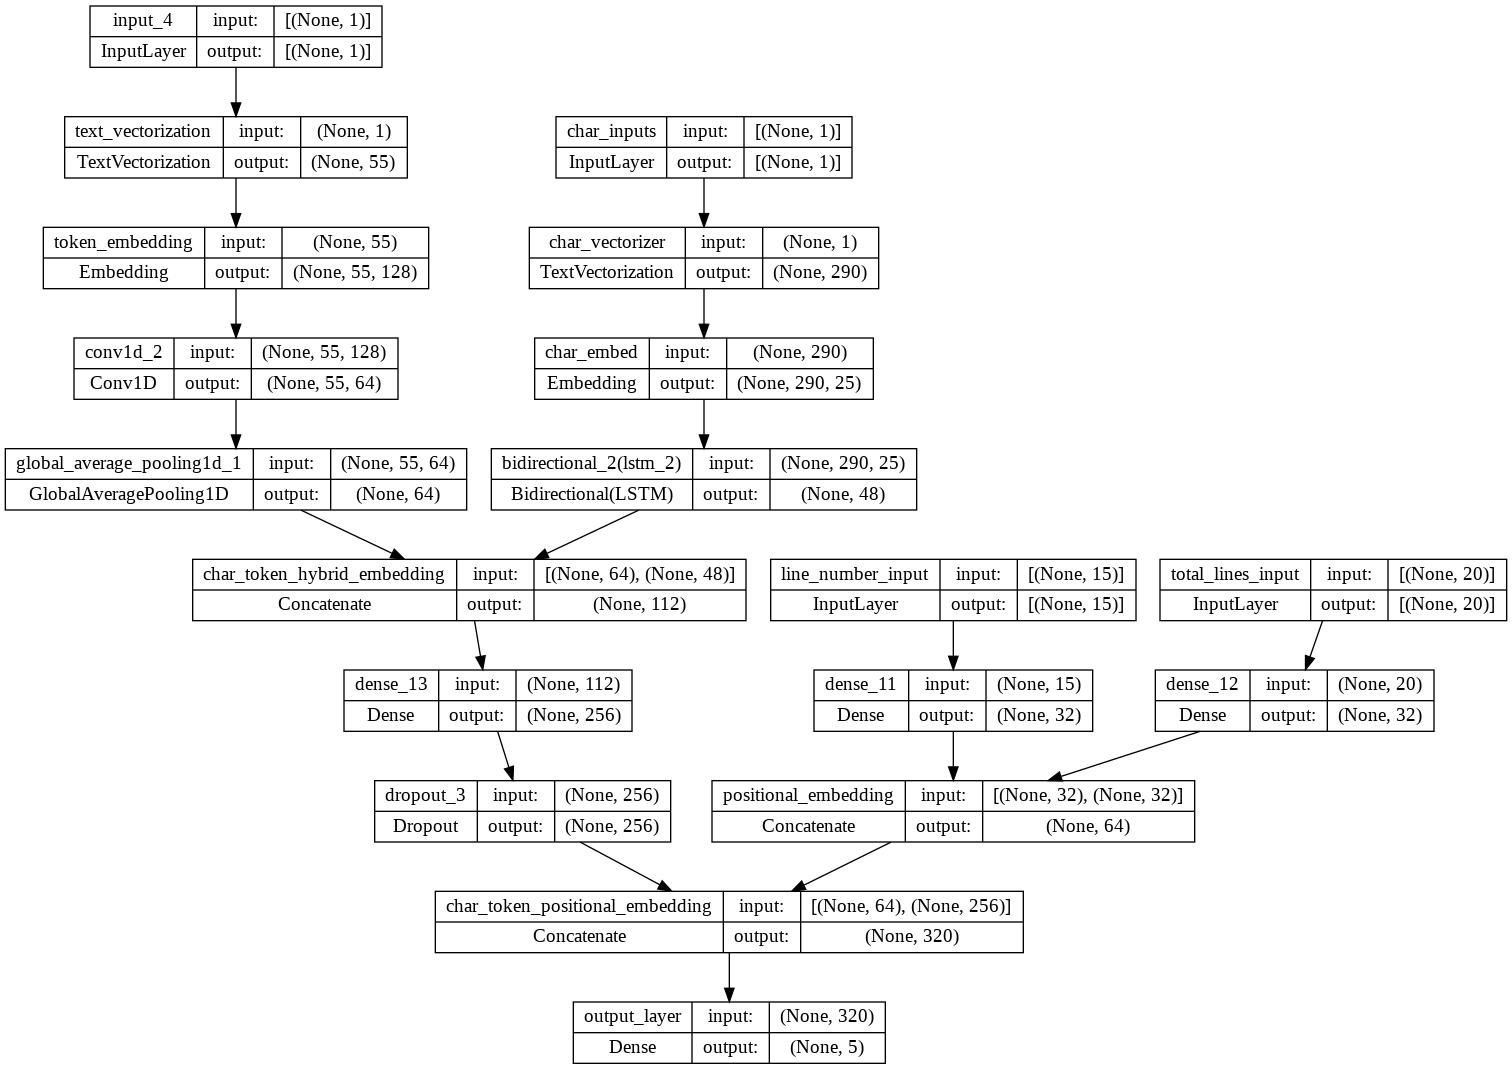

In [91]:
# Plot model
plot_model(model_6, show_shapes=True)

In [92]:
# Fit our tribrid embedding model
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 24s 33ms/step - loss: 1.0091 - accuracy: 0.7946 - val_loss: 0.9329 - val_accuracy: 0.8447
Epoch 2/3
562/562 [==============================] - 18s 32ms/step - loss: 0.8964 - accuracy: 0.8698 - val_loss: 0.9204 - val_accuracy: 0.8361
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.8823 - accuracy: 0.8783 - val_loss: 0.9092 - val_accuracy: 0.8431


In [93]:
# Evaluate the model
model_6.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 12s 12ms/step - loss: 0.9054 - accuracy: 0.8473


[0.9053918123245239, 0.847312331199646]

In [94]:
# Make predicitons
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

# Caculate results
model_6_results = calculate_results(val_labels_encoded,
                                    model_6_preds)
model_6_results

945/945 [==============================] - 12s 12ms/step


{'accuracy': 84.73123262279888,
 'precision': 0.8462362654957363,
 'recall': 0.8473123262279889,
 'f1': 0.8461190782727588}

## Compare model results

In [95]:
# Combine model results into a dataframe
all_models_results = pd.DataFrame({"model_0_baseline":model_0_results,
                                   "model_1_custom_token_embedding":model_1_results,
                                   "model_2_pretrained_token_embedding":model_2_results,
                                   "model_3_custom_char_embedding":model_3_results,
                                   "model_4_hybrid_char_token_embedding":model_4_results,
                                   "model_5_pos_char_token_embedding":model_5_results,
                                   "model_6_custom_char_token_+_pos_embedding":model_6_results})

all_models_results = all_models_results.T
all_models_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.700516,0.784128,0.787005,0.784686
model_2_pretrained_token_embedding,71.547729,0.715671,0.715477,0.712439
model_3_custom_char_embedding,68.376804,0.676956,0.683768,0.673858
model_4_hybrid_char_token_embedding,73.229180,0.735213,0.732292,0.729608
model_5_pos_char_token_embedding,83.132530,0.829957,0.831325,0.830329
model_6_custom_char_token_+_pos_embedding,84.731233,0.846236,0.847312,0.846119


In [96]:
# Reduce the accuracy to same scale as other metrics
all_models_results["accuracy"] = all_models_results["accuracy"]/100

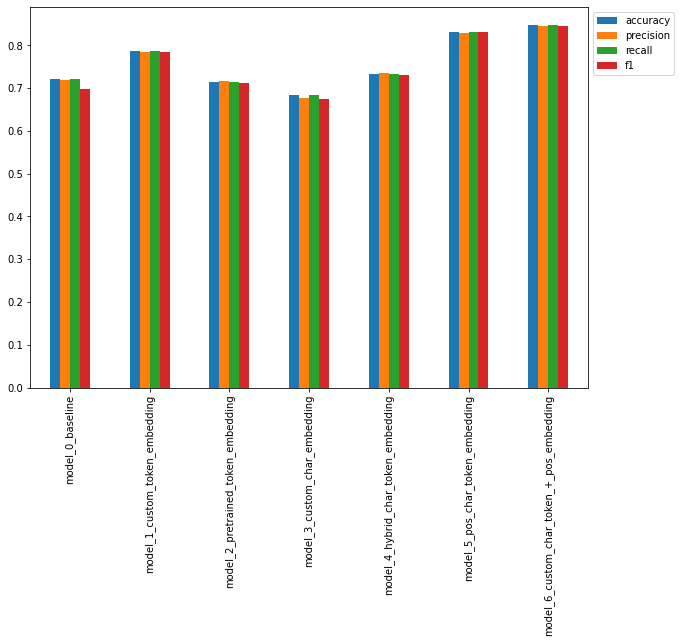

In [97]:
# Plot and compare all model results
all_models_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

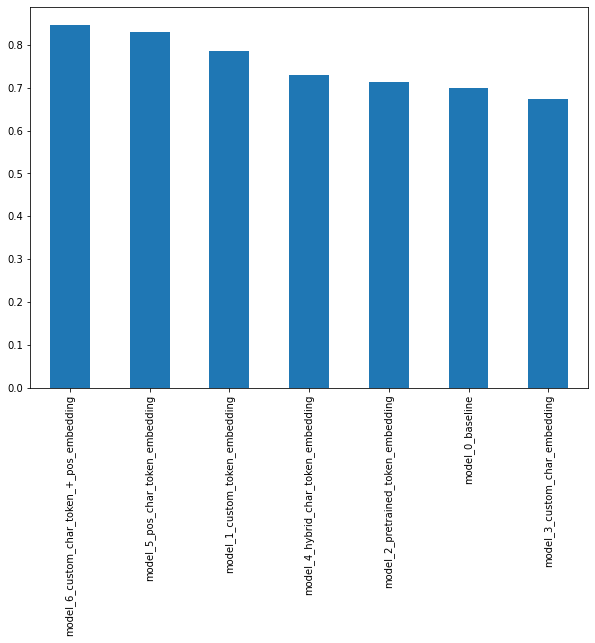

In [98]:
# Sort models results by f1-score
all_models_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

Based on the figures above, model_6 is best model we have created so far, and its performance is so close to model 5. Therefore, let's fit both of them on 100% of the PubMed_20k_RCT training dataset

### Fit model_5 on 100% of the training dataset of PubMed_20k_RCT

In [99]:
history_model_5_extended = model_5.fit(train_char_token_pos_dataset,
                                       epochs=6,
                                       validation_data=val_char_token_pos_dataset,
                                       validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
                                       initial_epoch=3)

Epoch 4/6
5627/5627 [==============================] - 171s 30ms/step - loss: 0.9252 - accuracy: 0.8431 - val_loss: 0.9067 - val_accuracy: 0.8517
Epoch 5/6
5627/5627 [==============================] - 172s 30ms/step - loss: 0.9050 - accuracy: 0.8574 - val_loss: 0.9044 - val_accuracy: 0.8481
Epoch 6/6
5627/5627 [==============================] - 173s 31ms/step - loss: 0.8942 - accuracy: 0.8650 - val_loss: 0.8994 - val_accuracy: 0.8471


In [100]:
# Evaluate the model
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.8957 - accuracy: 0.8566


[0.8957453370094299, 0.8566463589668274]

In [101]:
# Make predicitons
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

# Caculate results
model_5_extended_results = calculate_results(val_labels_encoded,
                                             model_5_preds)
model_5_extended_results

945/945 [==============================] - 19s 21ms/step


{'accuracy': 85.66463656825103,
 'precision': 0.8582798523948777,
 'recall': 0.8566463656825103,
 'f1': 0.8539888585241773}

### Fit model_6 on 100% of the training dataset of PubMed_20k_RCT

In [102]:
history_model_6_extended = model_6.fit(train_char_token_pos_dataset,
                                       epochs=6,
                                       validation_data=val_char_token_pos_dataset,
                                       validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
                                       initial_epoch=3)

Epoch 4/6
5627/5627 [==============================] - 141s 25ms/step - loss: 0.8830 - accuracy: 0.8752 - val_loss: 0.8899 - val_accuracy: 0.8610
Epoch 5/6
5627/5627 [==============================] - 140s 25ms/step - loss: 0.8458 - accuracy: 0.9003 - val_loss: 0.8841 - val_accuracy: 0.8650
Epoch 6/6
5627/5627 [==============================] - 142s 25ms/step - loss: 0.8109 - accuracy: 0.9254 - val_loss: 0.8983 - val_accuracy: 0.8527


In [103]:
# Evaluate the model
model_6.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.8884 - accuracy: 0.8627


[0.8884270787239075, 0.8627035617828369]

In [104]:
# Make predicitons
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

# Caculate results
model_6_extended_results = calculate_results(val_labels_encoded,
                                             model_6_preds)
model_6_extended_results

945/945 [==============================] - 11s 12ms/step


{'accuracy': 86.27035614987422,
 'precision': 0.8630037049982107,
 'recall': 0.8627035614987422,
 'f1': 0.8606837096334893}

In [105]:
# Combine model results into a dataframe
extended_results = pd.DataFrame({"model_5_original":model_5_results,
                                 "model_6_original":model_6_results,
                                 "model_5_extended":model_5_extended_results,
                                 "model_6_extended":model_6_extended_results})

extended_results = extended_results.T
extended_results

,accuracy,precision,recall,f1
model_5_original,83.132530,0.829957,0.831325,0.830329
model_6_original,84.731233,0.846236,0.847312,0.846119
model_5_extended,85.664637,0.858280,0.856646,0.853989
model_6_extended,86.270356,0.863004,0.862704,0.860684


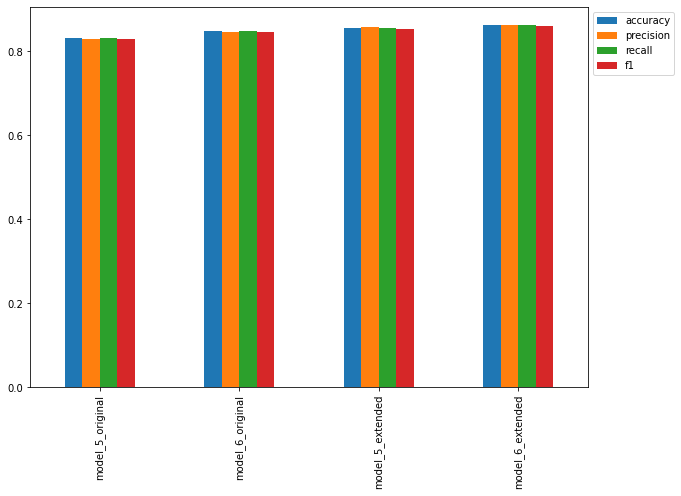

In [106]:
# Reduce the accuracy to same scale as other metrics
extended_results["accuracy"] = extended_results["accuracy"]/100

# Plot and compare all model results
extended_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

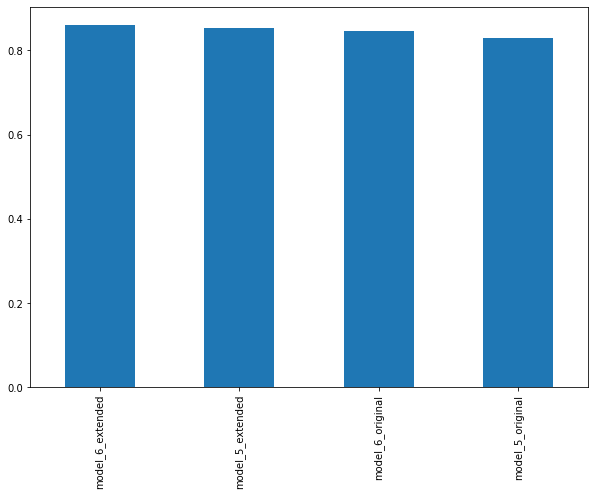

In [107]:
# Sort models results by f1-score
extended_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

In [108]:
def compare_models_histories(model_1_history, model_1_extended_history, model_2_history, model_2_extended_history, initial_epochs=3):
   
    # Get original history measurements for model 1
    model_1_acc = model_1_history.history["accuracy"]
    model_1_loss = model_1_history.history["loss"]

    model_1_val_acc = model_1_history.history["val_accuracy"]
    model_1_val_loss = model_1_history.history["val_loss"]

    # Combine original history with new history
    model_1_total_acc = model_1_acc + model_1_extended_history.history["accuracy"]
    model_1_total_loss = model_1_loss + model_1_extended_history.history["loss"]

    model_1_total_val_acc = model_1_val_acc + model_1_extended_history.history["val_accuracy"]
    model_1_total_val_loss = model_1_val_loss + model_1_extended_history.history["val_loss"]


    # Do the same for model 2
    model_2_acc = model_2_history.history["accuracy"]
    model_2_loss = model_2_history.history["loss"]

    model_2_val_acc = model_2_history.history["val_accuracy"]
    model_2_val_loss = model_2_history.history["val_loss"]

    model_2_total_acc = model_2_acc + model_2_extended_history.history["accuracy"]
    model_2_total_loss = model_2_loss + model_2_extended_history.history["loss"]

    model_2_total_val_acc = model_2_val_acc + model_2_extended_history.history["val_accuracy"]
    model_2_total_val_loss = model_2_val_loss + model_2_extended_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(16, 16))
    plt.subplot(2, 2, 1)
    plt.plot(model_1_total_acc, label='Training Accuracy Model 1')
    plt.plot(model_1_total_val_acc, label='Validation Accuracy Model 1')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy For model 1')

    plt.subplot(2, 2, 2)
    plt.plot(model_1_total_loss, label='Training Loss Model 1')
    plt.plot(model_1_total_val_loss, label='Validation Loss Model 1')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss For Model 1')

    plt.subplot(2, 2, 3)
    plt.plot(model_2_total_acc, label='Training Accuracy Model 2')
    plt.plot(model_2_total_val_acc, label='Validation Accuracy Model 2')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy For model 2')

    plt.subplot(2, 2, 4)
    plt.plot(model_2_total_loss, label='Training Loss Model 2')
    plt.plot(model_2_total_val_loss, label='Validation Loss Model 2')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss For Model 2')
    plt.xlabel('epoch')
    plt.show()

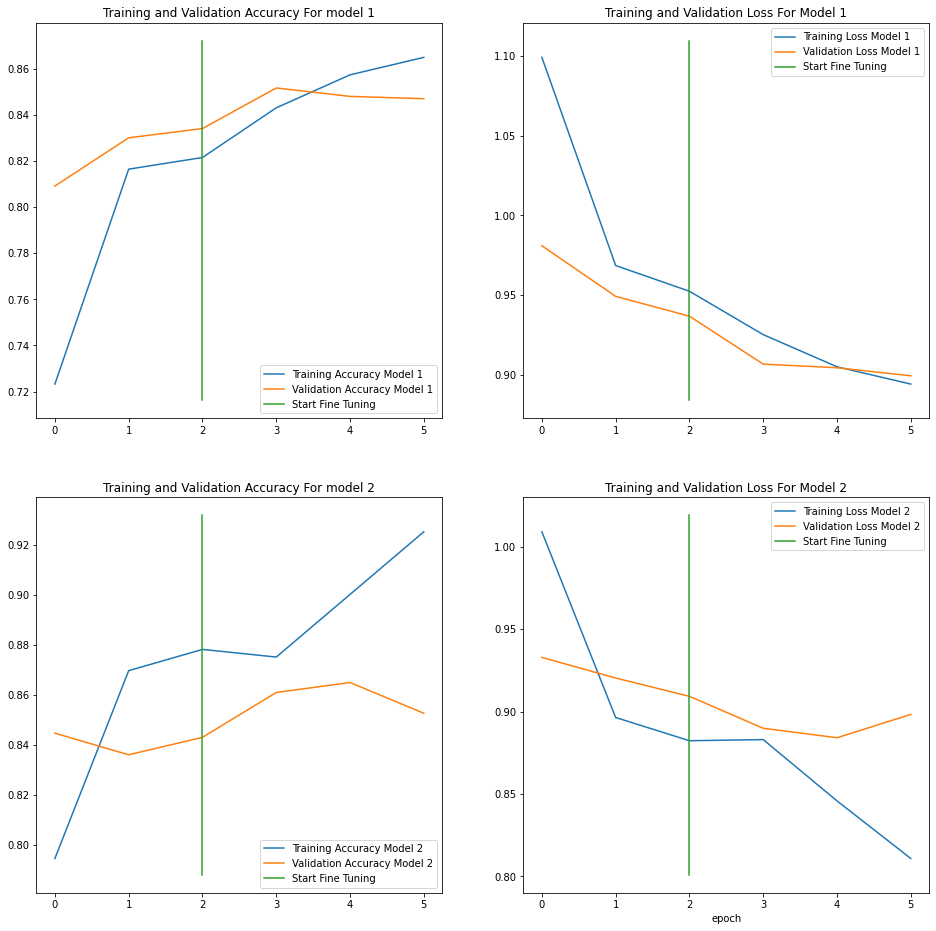

In [109]:
compare_models_histories(history_model_5, history_model_5_extended, history_model_6, history_model_6_extended)

Based on all of the above, though model 6 has a slightly better overall metrics, it is more vulnerable of overfitting than model 5, therefore, we will use model 5 for the rest of this notebook.

## Model-Driven Data Exploration

### Create test Dataset

In [116]:
# Create test dataset with all four kinds of input data
test_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                 test_total_lines_one_hot,
                                                 test_sentences,
                                                 test_chars))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Find results of the model on test data

In [119]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_dataset,
                                  verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [120]:
test_results = calculate_results(y_true=test_labels_encoded,
                                 y_pred=test_preds)
test_results

{'accuracy': 84.93446158951386,
 'precision': 0.8514838990959823,
 'recall': 0.8493446158951385,
 'f1': 0.8450002565697295}

### Find most wrong predictions

In [122]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:15]

['BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS']

In [123]:
# Add prediction information to the dataset
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = np.equal(test_df["prediction"], test_df["target"]) # create binary column for whether the prediction is right or not
test_df.head(20)

,line_number,target,text,total_lines,prediction,pred_prob,correct
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8,BACKGROUND,0.356979,True
1,1,RESULTS,a post hoc analysis was conducted with the use...,8,METHODS,0.640948,False
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8,METHODS,0.810438,False
3,3,RESULTS,survival analyses were used to assess the asso...,8,METHODS,0.822174,False
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8,RESULTS,0.741115,True
5,5,RESULTS,when mean hemodynamic profiles were compared i...,8,RESULTS,0.842744,True
6,6,RESULTS,multivariable analyses revealed that patients ...,8,RESULTS,0.683361,True
7,7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,8,CONCLUSIONS,0.758588,True
8,8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,CONCLUSIONS,0.647147,True
9,0,BACKGROUND,minimally invasive endovascular aneurysm repai...,12,BACKGROUND,0.653797,True


In [124]:
# Get top 50 most wrong samples
top_50_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:50]
top_50_wrong

,line_number,target,text,total_lines,prediction,pred_prob,correct
8545,1,METHODS,pretest-posttest .,11,BACKGROUND,0.968702,False
20427,1,OBJECTIVE,the national institute of neurological disorde...,18,BACKGROUND,0.940597,False
22736,4,OBJECTIVE,"the national institute of oncology , budapest ...",20,METHODS,0.932120,False
13874,4,CONCLUSIONS,symptom outcomes will be assessed and estimate...,6,METHODS,0.931481,False
29692,3,RESULTS,repeated measures analysis of variance ( anova...,6,METHODS,0.925512,False
29294,4,RESULTS,"baseline measures included sociodemographics ,...",13,METHODS,0.922389,False
3573,3,RESULTS,a cluster randomised trial was implemented wit...,16,METHODS,0.917821,False
16780,16,METHODS,we will comply with the consort guidelines and...,19,BACKGROUND,0.916624,False
1827,18,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,BACKGROUND,0.913371,False
4391,15,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,BACKGROUND,0.911984,False


In [128]:
# Investigate top wrong preds
for row in top_50_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob:.4f}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 1, Pred: BACKGROUND, Prob: 0.9687, Line number: pretest-posttest ., Total lines: 11

Text:
METHODS

-----

Target: 1, Pred: BACKGROUND, Prob: 0.9406, Line number: the national institute of neurological disorders and stroke exploratory trials in parkinson disease program was established to promote discovery of potential therapies ., Total lines: 18

Text:
OBJECTIVE

-----

Target: 4, Pred: METHODS, Prob: 0.9321, Line number: the national institute of oncology , budapest conducted a single centre randomized clinical study ., Total lines: 20

Text:
OBJECTIVE

-----

Target: 4, Pred: METHODS, Prob: 0.9315, Line number: symptom outcomes will be assessed and estimates of cost-effectiveness made ., Total lines: 6

Text:
CONCLUSIONS

-----

Target: 3, Pred: METHODS, Prob: 0.9255, Line number: repeated measures analysis of variance ( anova ) tests were conducted to examine the differences across conditions and time ., Total lines: 6

Text:
RESULTS

-----

Target: 4, Pred: METHODS, Prob:

## Save the model

In [130]:
# Save model in SavedModel type
model_5.save("SkimLit_Project_Model")

In [133]:
# Zip and Download File
!zip -r /content/model.zip /content/SkimLit_Project_Model
from google.colab import files
files.download("/content/model.zip")

  adding: content/SkimLit_Project_Model/ (stored 0%)
  adding: content/SkimLit_Project_Model/keras_metadata.pb (deflated 91%)
  adding: content/SkimLit_Project_Model/saved_model.pb (deflated 72%)
  adding: content/SkimLit_Project_Model/variables/ (stored 0%)
  adding: content/SkimLit_Project_Model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/SkimLit_Project_Model/variables/variables.index (deflated 77%)
  adding: content/SkimLit_Project_Model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test the model on a real abstarct from the internet

In [156]:
# Read the example.txt file
def preprocess_custom_file(filepath):

  # Step one read file
  example_abstract = get_lines("example.txt")
  example_abstract

# Step two get sentences
  example_sentences = []
  nlp = spacy.load("en_core_web_sm")
  doc = nlp(example_abstract[0])
  assert doc.has_annotation("SENT_START")
  for sent in doc.sents:
      example_sentences.append(sent.text)

# Step three create a dict
  # Get total number of lines
  total_lines_in_abstract = len(example_sentences)

  # Go through each line in abstract and create a list of dictionaries containing features for each line
  abstract_lines = []
  for i, line in enumerate(example_sentences):
    abstract_dict = {}
    abstract_dict["text"] = str(line)
    abstract_dict["line_number"] = i
    abstract_dict["total_lines"] = total_lines_in_abstract - 1
    abstract_lines.append(abstract_dict)

# Step four add line numbers
  # Get all line_number values from abstract lines
  test_abstract_line_numbers = [line["line_number"] for line in abstract_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 

# Step five add total lines 
  # Get all total_lines values from abstract lines
  test_abstract_total_lines = [line["total_lines"] for line in abstract_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

# Step six split into chars
  # Split abstract lines into characters
  abstract_chars = [split_chars(sentence) for sentence in example_sentences]
  abstract_chars

  return test_abstract_line_numbers_one_hot, test_abstract_total_lines_one_hot, example_sentences, abstract_chars

In [157]:
# Preprocess the file
test_abstract_line_numbers_one_hot, test_abstract_total_lines_one_hot, example_sentences, abstract_chars = preprocess_custom_file("example.txt")
example_sentences

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [158]:
# Make predictions
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                              test_abstract_total_lines_one_hot,
                                              tf.constant(example_sentences),
                                              tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step


array([[0.38621342, 0.08759625, 0.08937116, 0.3954708 , 0.04134828],
       [0.07691336, 0.04108024, 0.7375583 , 0.1054544 , 0.03899375],
       [0.06848221, 0.03913555, 0.72056234, 0.07479252, 0.09702738],
       [0.09914888, 0.21973597, 0.5180912 , 0.07272311, 0.09030088],
       [0.06623973, 0.10769087, 0.33342996, 0.05044871, 0.44219077],
       [0.02505478, 0.03410701, 0.8009749 , 0.03492338, 0.10494   ],
       [0.02247758, 0.07048672, 0.06474645, 0.02398404, 0.8183052 ],
       [0.01184751, 0.06931778, 0.10535159, 0.02194285, 0.7915403 ]],
      dtype=float32)

In [160]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)

# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(example_sentences):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
